In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

df = pd.read_csv('/kaggle/input/u-novus/data/all.csv')
df['Период'] = pd.to_datetime(df['Период'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values('Период')
df = df.dropna()

label_encoder = LabelEncoder()
df['Пост мониторинга'] = label_encoder.fit_transform(df['Пост мониторинга'])

columns_to_drop = ['NO2', 'O3', 'H2S', 'CO', 'SO2']
df = df.drop(columns=columns_to_drop)

features = ['Температура, °С', 'Давление, мм рт. ст.', 'Влажность, %', 'Скорость ветра, м/с', 'Направление ветра, °']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [ ]:
input_steps = 72  
output_steps = 72  

X_catboost = []
Y_catboost = []

for i in range(len(scaled_data) - input_steps - output_steps):
    x = scaled_data[i:i + input_steps].flatten()  
    y = scaled_data[i + input_steps:i + input_steps + output_steps].flatten()  
    X_catboost.append(x)
    Y_catboost.append(y)

X_catboost = np.array(X_catboost)
Y_catboost = np.array(Y_catboost)

print("X shape:", X_catboost.shape)
print("Y shape:", Y_catboost.shape)

X shape: (6241, 360)
Y shape: (6241, 360)


In [ ]:
total_samples = len(X_catboost)

train_end = int(total_samples * 0.8)
val_start = train_end + output_steps
val_end = val_start + int(total_samples * 0.1)

finetune_start = val_end + output_steps

X_train = X_catboost[:train_end]
Y_train = Y_catboost[:train_end]

X_val = X_catboost[val_start:val_end]
Y_val = Y_catboost[val_start:val_end]

X_finetune = X_catboost[finetune_start:]
Y_finetune = Y_catboost[finetune_start:]

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Finetune shape: {X_finetune.shape}")


Train shape: (4992, 360)
Validation shape: (624, 360)
Finetune shape: (481, 360)


In [ ]:
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

base_model = CatBoostRegressor(
    iterations=2,
    learning_rate=0.05,
    depth=6,
    verbose=1,
    early_stopping_rounds=2,
    task_type='GPU' 
)


model = CatBoostRegressor(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiRMSE',
    verbose=1,
    task_type='GPU'
)
model.fit(X_train, Y_train)

from sklearn.metrics import r2_score

feature_cols = ['temperature', 'pressure', 'humidity', 'wind_speed', 'wind_direction']
y_val_pred = model.predict(X_val)
for i in range(5):
    r2 = r2_score(Y_val[:, i::5].flatten(), y_val_pred[:, i::5].flatten())
    print(f"{feature_cols[i]}: R² = {r2:.4f}")

0:	learn: 3.9309874	total: 15.1s	remaining: 1h 40m 15s
1:	learn: 3.8488202	total: 15.8s	remaining: 52m 19s
2:	learn: 3.7706504	total: 16.5s	remaining: 36m 27s
3:	learn: 3.6961118	total: 17.3s	remaining: 28m 34s
4:	learn: 3.6267962	total: 18.1s	remaining: 23m 46s
5:	learn: 3.5616851	total: 18.8s	remaining: 20m 31s
6:	learn: 3.4996955	total: 19.4s	remaining: 18m 11s
7:	learn: 3.4409969	total: 20.1s	remaining: 16m 25s
8:	learn: 3.3844195	total: 20.8s	remaining: 15m 5s
9:	learn: 3.3302302	total: 21.6s	remaining: 14m
10:	learn: 3.2803055	total: 22.3s	remaining: 13m 7s
11:	learn: 3.2329669	total: 23s	remaining: 12m 25s
12:	learn: 3.1859088	total: 23.7s	remaining: 11m 46s
13:	learn: 3.1423466	total: 24.5s	remaining: 11m 14s
14:	learn: 3.0998901	total: 25.1s	remaining: 10m 45s
15:	learn: 3.0601346	total: 25.8s	remaining: 10m 18s
16:	learn: 3.0224100	total: 26.5s	remaining: 9m 56s
17:	learn: 2.9849582	total: 27.2s	remaining: 9m 37s
18:	learn: 2.9513183	total: 27.9s	remaining: 9m 19s
19:	learn: 

In [6]:
X_full = np.vstack([X_train, X_finetune])
Y_full = np.vstack([Y_train, Y_finetune])

final_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiRMSE',
    verbose=1,
    task_type='GPU'
)

final_model.fit(X_full, Y_full)

0:	learn: 3.9474444	total: 753ms	remaining: 2m 29s
1:	learn: 3.8649406	total: 1.53s	remaining: 2m 31s
2:	learn: 3.7882633	total: 2.28s	remaining: 2m 30s
3:	learn: 3.7155595	total: 3.04s	remaining: 2m 29s
4:	learn: 3.6471762	total: 3.81s	remaining: 2m 28s
5:	learn: 3.5816804	total: 4.58s	remaining: 2m 28s
6:	learn: 3.5209238	total: 5.39s	remaining: 2m 28s
7:	learn: 3.4627048	total: 6.17s	remaining: 2m 28s
8:	learn: 3.4038848	total: 6.95s	remaining: 2m 27s
9:	learn: 3.3495698	total: 7.68s	remaining: 2m 25s
10:	learn: 3.2972480	total: 8.44s	remaining: 2m 25s
11:	learn: 3.2494927	total: 9.16s	remaining: 2m 23s
12:	learn: 3.2031224	total: 9.93s	remaining: 2m 22s
13:	learn: 3.1582908	total: 10.7s	remaining: 2m 21s
14:	learn: 3.1167231	total: 11.4s	remaining: 2m 20s
15:	learn: 3.0779103	total: 12.1s	remaining: 2m 19s
16:	learn: 3.0419305	total: 12.8s	remaining: 2m 17s
17:	learn: 3.0052333	total: 13.5s	remaining: 2m 16s
18:	learn: 2.9714170	total: 14.3s	remaining: 2m 16s
19:	learn: 2.9373433	t

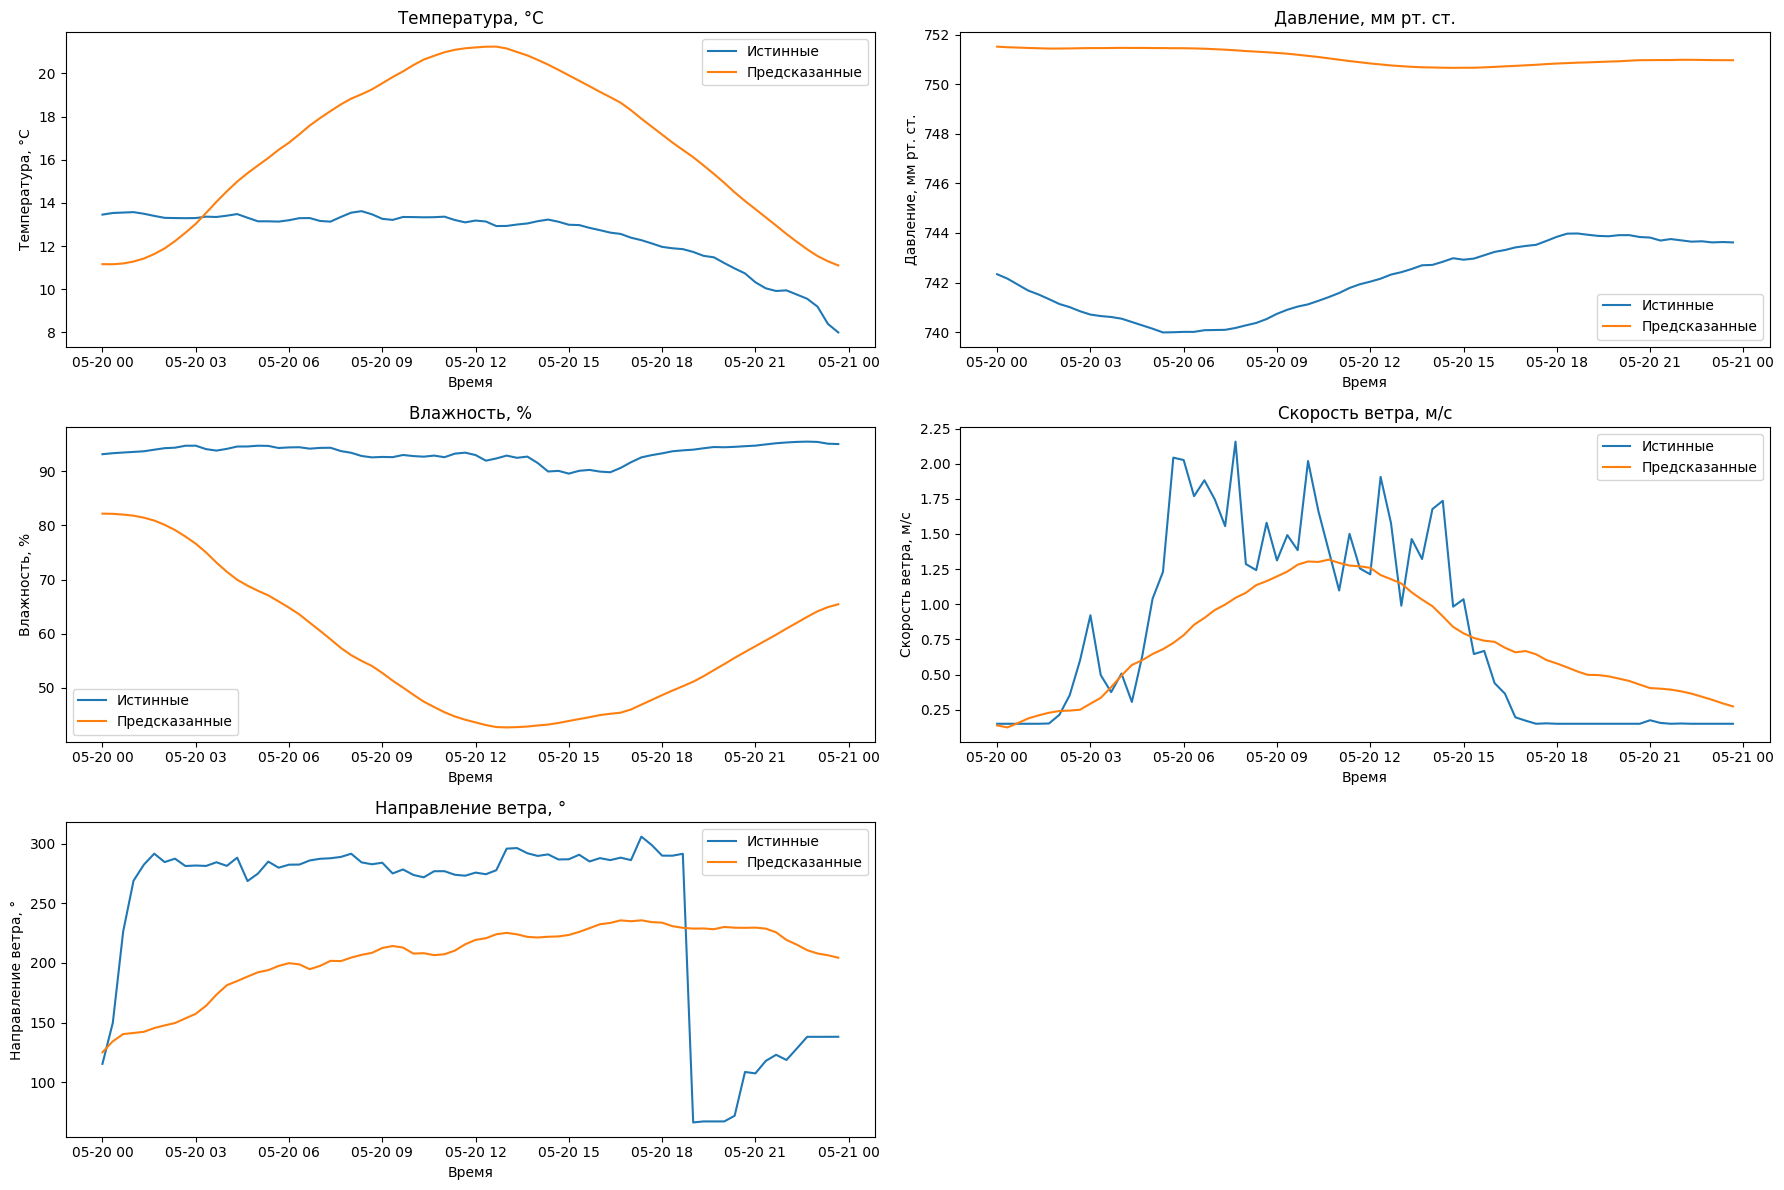

In [ ]:
import matplotlib.pyplot as plt

input_steps = 144
output_steps = 72
feature_cols = ['Температура, °С', 'Давление, мм рт. ст.', 'Влажность, %', 'Скорость ветра, м/с', 'Направление ветра, °']

df_test = pd.read_csv('/kaggle/input/u-novus/data/test.csv')
df_test['Период'] = pd.to_datetime(df_test['Период'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_test = df_test.dropna(subset=['Период']).sort_values(by='Период', ascending=True)
df_test['Пост мониторинга'] = LabelEncoder().fit_transform(df_test['Пост мониторинга'])
df_test = df_test.drop(columns=['NO2', 'O3', 'H2S', 'CO', 'SO2'])

test_scaled = scaler.transform(df_test[feature_cols])


X_test_input = scaled_data[-input_steps:]  
X_test_input = X_test_input.reshape((1, input_steps, len(feature_cols)))

X_test_input_flat = X_test_input.flatten().reshape(1, -1)

y_test_pred_scaled = model.predict(X_test_input_flat)  
y_test_pred_scaled = y_test_pred_scaled.reshape((output_steps, len(feature_cols)))

y_test_pred = scaler.inverse_transform(y_test_pred_scaled)

Y_test_true = df_test[feature_cols].values 

time_index = df_test['Период']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(feature_cols):
    plt.subplot(3, 2, i+1)
    plt.plot(time_index, Y_test_true[:, i], label='Истинные')
    plt.plot(time_index, y_test_pred[:, i], label='Предсказанные')
    plt.title(feature)
    plt.xlabel('Время')
    plt.ylabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()
